<a href="https://colab.research.google.com/github/arshakRz/GVS-Neuromodulation_Analysis/blob/main/BVP_Tags.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.signal import butter, filtfilt, lfilter, iirnotch, resample
from scipy import stats


plt.rcParams['figure.figsize'] = [16, 8]
#plt.rcParams.update({'font.size':18})

In [ ]:
#%% FUNCTIONS

def butter_bandpass_filter(data, lowcut, highcut, sRate, order=4):
    nyq = 0.5 * sRate
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='bandpass')
    y = filtfilt(b, a, data)
    return y

def notch_filter(signal, fs, filter_range=[50, 60]):
    for f0 in filter_range:  # Frequency to be removed from signal (Hz)
        Q = 30.0  # Quality factor
        w0 = f0 / (fs / 2)  # Normalized Frequency
        b, a = iirnotch(w0, Q)
        for i in range(signal.shape[-1]):
            signal[:, i] = lfilter(b, a, signal[:, i])

    return signal

def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    y = filtfilt(b, a, data)
    return y

def resample_frequency(signal, seg_len, new_fs, old_fs):
    """
    Resample the signal to a new frequency and keeping the time fixed
    args:
        signal (np.array): ecg signal
        seg_len (int): length of the signal in seconds
        new_fs (int): frequency after resampling
        old_fs (int): frequency before resampling
    returns:
        resampled signal (np.array)
    """
    if seg_len is None:
        num = int(len(signal) / old_fs * new_fs)
    else:
        num = int(seg_len * new_fs)
    return resample(signal, num=num)

In [ ]:
#############################
def plot_windows(loc, sub, standing_inds, tr, lims):
  standing_inds_ = []
  standing_inds_.append(standing_inds[tr-1])
  standing_inds_.append(standing_inds[tr+2])
  standing_inds = standing_inds_
  path = loc + 'BVP.csv'
  df = pd.read_csv(path)
  init_time = int(float(df.columns.values.tolist()[0]))
  fs_bvp = df.values[0]
  bvp = np.squeeze(df.values[1:])
  dt = 1/fs_bvp
  sample_no = bvp.shape[0]
  endtime = sample_no * dt
  t = np.linspace(0, endtime, sample_no)
  path = loc + 'tags.csv'
  df = pd.read_csv(path)
  keys = df.keys()
  tags = np.array(df[keys[0]])
  inds = np.round((tags-init_time)*fs_bvp)
  inds = inds.astype(np.int32)
  w = 5000
  offset = 600
  shift = 50
  count = 0
  fig, ax = plt.subplots()
  offsets = []
  for num in standing_inds:
    tag = inds[num]
    count += 1
    plt.subplot(2, 1, count)
    if count == 1:
      tit = "Sham Trial " + str(tr)
    else:
      tit = "GVS Trial " + str(tr)
    #offset_ = plot_window(t, bvp, tag, w, offset, shift, tit, fs_bvp, lims)
    plot_window(t, bvp, tag, w, offset, shift, tit, fs_bvp, lims)
    #offsets.append(offset_)
  plt.suptitle("OH"+str(sub)+" ")
  fig.legend(["Abs of BVP",  "Tag With Offset", "Original Tag"], loc = 'right')
  plt.subplots_adjust(right=0.9)
  plt.savefig('BVP_plots/OH'+str(sub)+'.png')
  plt.show()
  #return offsets
  ###############################

In [ ]:
#def plot_window(t, bvp, tag, w, max_offset , shift, tit, fs, lims):
def plot_window(t, bvp, tag, w, plt):
  #pvals = []
  #for i in range(-max_offset, max_offset + 1, shift):
    #moved_tag = tag + i
    #t_window = t[int(moved_tag-w//2): int(moved_tag+w//2)]
    #bvp_window = bvp[int(moved_tag-w//2): int(moved_tag+w//2)]
    #tt = stats.ttest_ind(np.abs(bvp[int(moved_tag-w//2):(int(moved_tag))]), np.abs(bvp[(int(moved_tag)):int(moved_tag+w//2)]), equal_var = False, alternative = 'greater')
    #pvals.append(tt[1])
  #best_tag = tag + (shift * pvals.index(min(pvals)) - max_offset)
  #best_pval = min(pvals)
  best_tag = tag
  t_window = t[int(best_tag-w//2): int(best_tag+w//2)]
  bvp_window = bvp[int(best_tag-w//2): int(best_tag+w//2)]
  bvp_window_lp = butter_lowpass_filter(np.abs(bvp_window), 0.5, fs, 4)
  #bvp_window_lp = bvp_window
  plt.plot(t_window, bvp_window_lp)
  plt.vlines(x = t[best_tag], ymin=-50, ymax=100, colors = 'green', ls='--')
  plt.xlim([t[best_tag]-50, t[best_tag]+50])
  #plt.ylim(lims)
  #plt.vlines(x = t[tag], ymin=lims[0], ymax=lims[1], colors = 'red', ls='--')
  #plt.title(tit+' (p-Value = '+"{:.3f}".format(best_pval)+')')
  #if min(pvals) < 0.05:
  #  best_offest = (shift * pvals.index(min(pvals)) - max_offset)
  #else:
  #  best_offest = None
  #return best_offest

In [ ]:
def plot_windows(loc, sub, standing_inds):
  path = loc + 'BVP.csv'
  df = pd.read_csv(path)
  init_time = int(float(df.columns.values.tolist()[0]))
  fs_bvp = df.values[0]
  bvp = np.squeeze(df.values[1:])
  dt = 1/fs_bvp
  sample_no = bvp.shape[0]
  endtime = sample_no * dt
  t = np.linspace(0, endtime, sample_no)
  path = loc + 'tags.csv'
  df = pd.read_csv(path)
  keys = df.keys()
  tags = np.array(df[keys[0]])
  inds = np.round((tags-init_time)*fs_bvp)
  inds = inds.astype(np.int32)
  w = 5000
  offset = 600
  shift = 50
  count = 0
  #fig, ax = plt.subplots()
  offsets = []
  fig = plt.figure()
  for num in standing_inds:
    tag = inds[num]
    count += 1
    #plt.hold(True)
    #plt.subplot(2, 3, count)
    if count<=3:
      #tit = "Sham Trial " + str(count)
      c = 'black'
      la = 'Sham ' + str(count)
    else:
      #tit = "GVS Trial " + str(count-3)
      c = 'red'
      la = 'GVS ' + str(count-3)
    #plot_window(t, bvp, tag, w, offset, shift, tit, fs_bvp)
    #plot_window(t, bvp, tag, w, plt)
    l = len(t[int(tag-w//2): int(tag+w//2)])
    t_window = range(l)/fs_bvp-l/(2*fs_bvp)
    bvp_window = bvp[int(tag-w//2): int(tag+w//2)]
    bvp_window_lp = butter_lowpass_filter(np.abs(bvp_window), 0.5, fs_bvp, 4)
    #bvp_window_lp = bvp_window
    plt.plot(t_window, bvp_window_lp, color = c, label=la)
    plt.vlines(x = t_window[l//2], ymin=min(bvp_window_lp), ymax=max(bvp_window_lp), colors = 'green', ls='--')
    #plt.xlim([t[tag]-50, t[tag]+50])
    #offset_ = plot_window(t, bvp, tag, w, offset, shift, tit, fs_bvp)
    #offsets.append(offset_)
  plt.title("OH"+str(sub)+" ")
  #fig.legend(["Abs of BVP",  "Tag With Offset", "Original Tag"], loc = 'right')
  #fig.legend(["Sham",  "GVS" ,"Tag"])
  fig.legend(loc = 'right')

  #plt.subplots_adjust(right=0.9)
  plt.savefig('BVP_plots/OH'+str(sub)+'.png')
  plt.show()

  #return offsets

In [ ]:
offsets = []

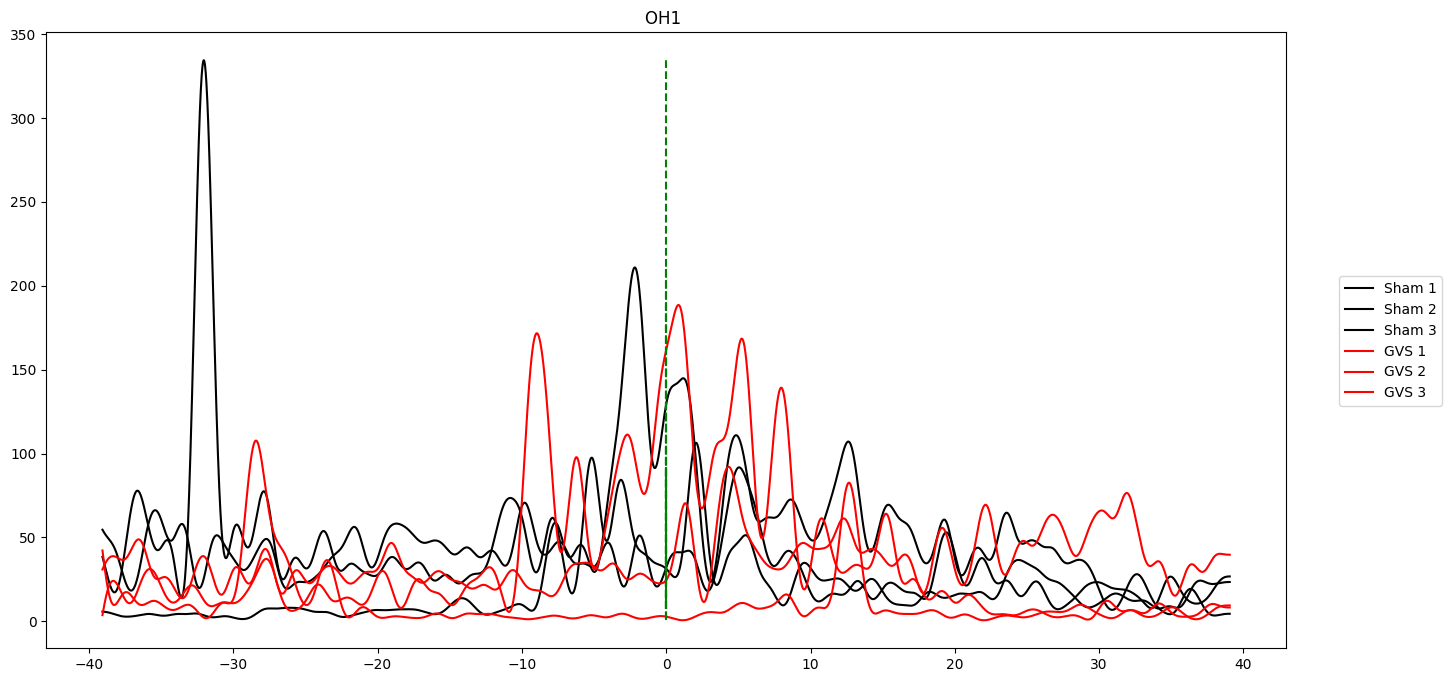

In [ ]:
loc = '/content/drive/MyDrive/DATA_untouched/OH01_April 14 2022_e4 data/'
standing_inds = [3, 7, 12, 21, 28, 33]
#offsets_ = plot_windows(loc, 1, standing_inds, 1, [-50, 250])
#offsets_ = plot_windows(loc, 1, standing_inds)
plot_windows(loc, 1, standing_inds)

#offsets.append(offsets_)

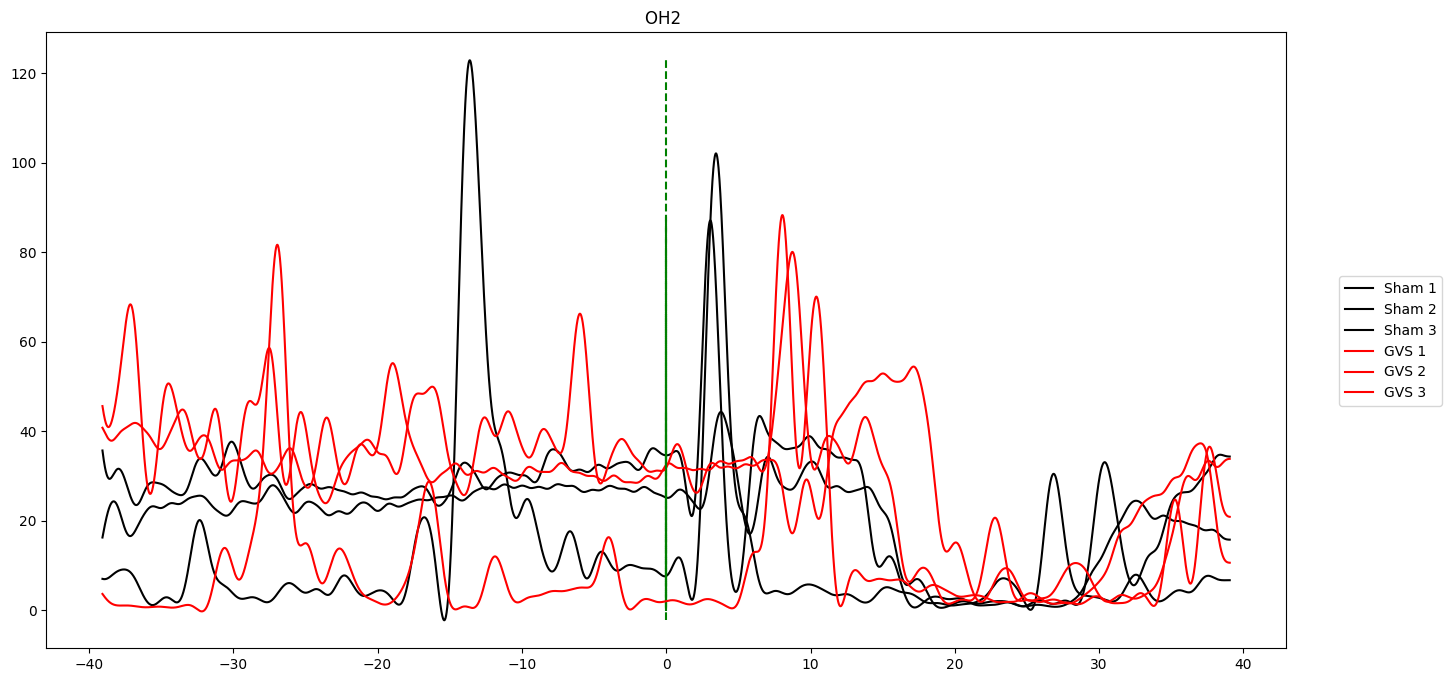

In [ ]:
loc = '/content/drive/MyDrive/DATA_untouched/OH02_April 19 2022_e4 data/'
standing_inds = [4, 9, 14, 22, 27, 32]
#offsets_ = plot_windows(loc, 2, standing_inds, 1, [-50, 150])
offsets_ = plot_windows(loc, 2, standing_inds)

#offsets.append(offsets_)

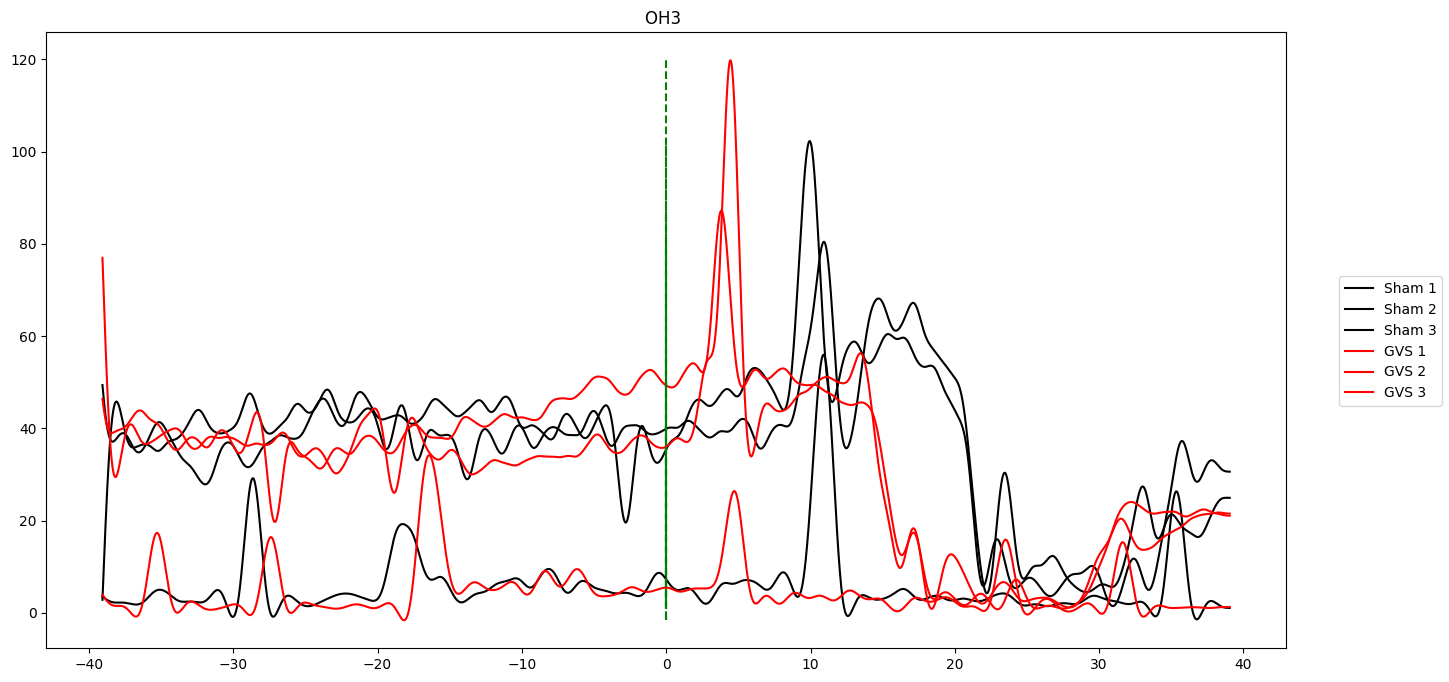

In [ ]:
loc = '/content/drive/MyDrive/DATA_untouched/OH03_April 20 2022_e4 data/'
standing_inds = [25, 30, 35, 7, 12, 16]
#offsets_ = plot_windows(loc, 3, standing_inds, 1, [-50, 150])
offsets_ = plot_windows(loc, 3, standing_inds)

#offsets.append(offsets_)

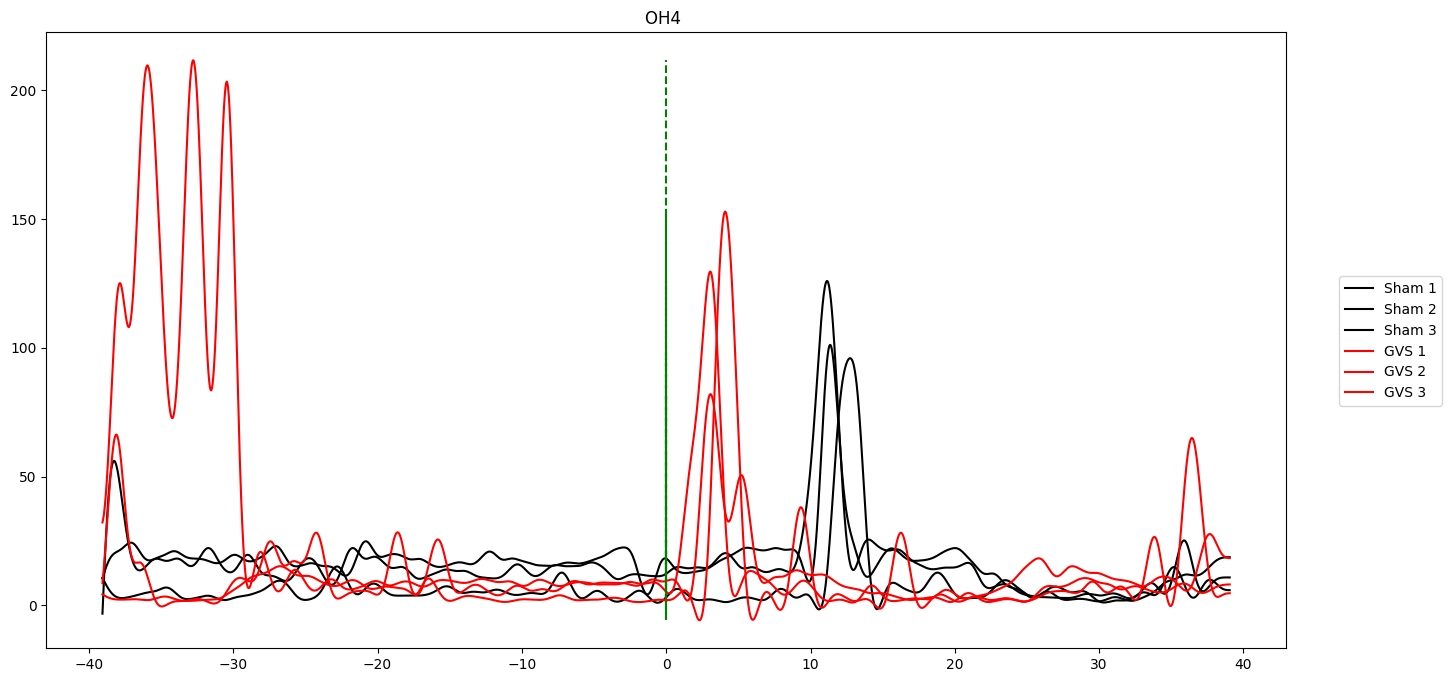

In [ ]:
loc = '/content/drive/MyDrive/DATA_untouched/OH04_April 22 2022_e4 data/'
standing_inds = [24, 29, 34, 3, 8, 13]
offsets_ = plot_windows(loc, 4, standing_inds)
#offsets.append(offsets_)

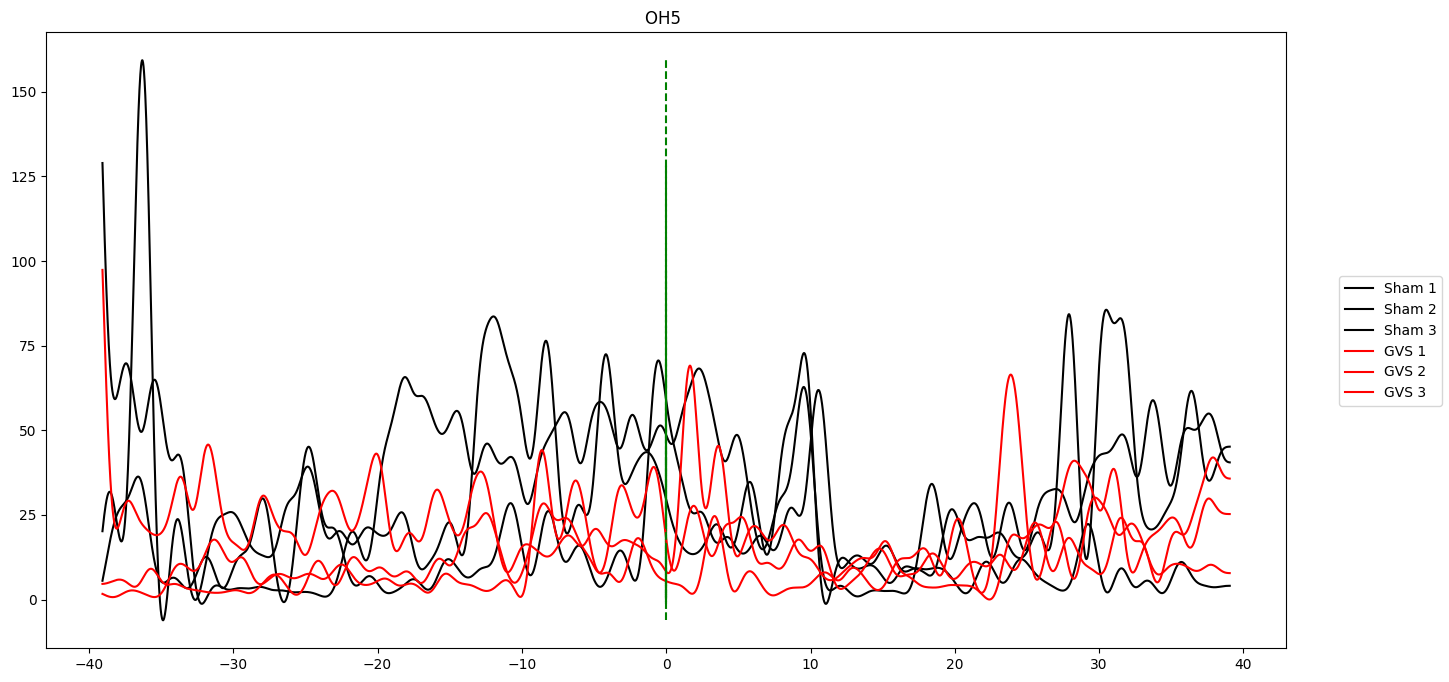

In [ ]:
loc = '/content/drive/MyDrive/DATA_untouched/OH05_April 22 2022_e4 data/'
standing_inds = [26, 30, 36, 4, 10, 17]
#offsets_ = plot_windows(loc, 5, standing_inds, 1, [-50, 150])
offsets_ = plot_windows(loc, 5, standing_inds)
#offsets.append(offsets_)

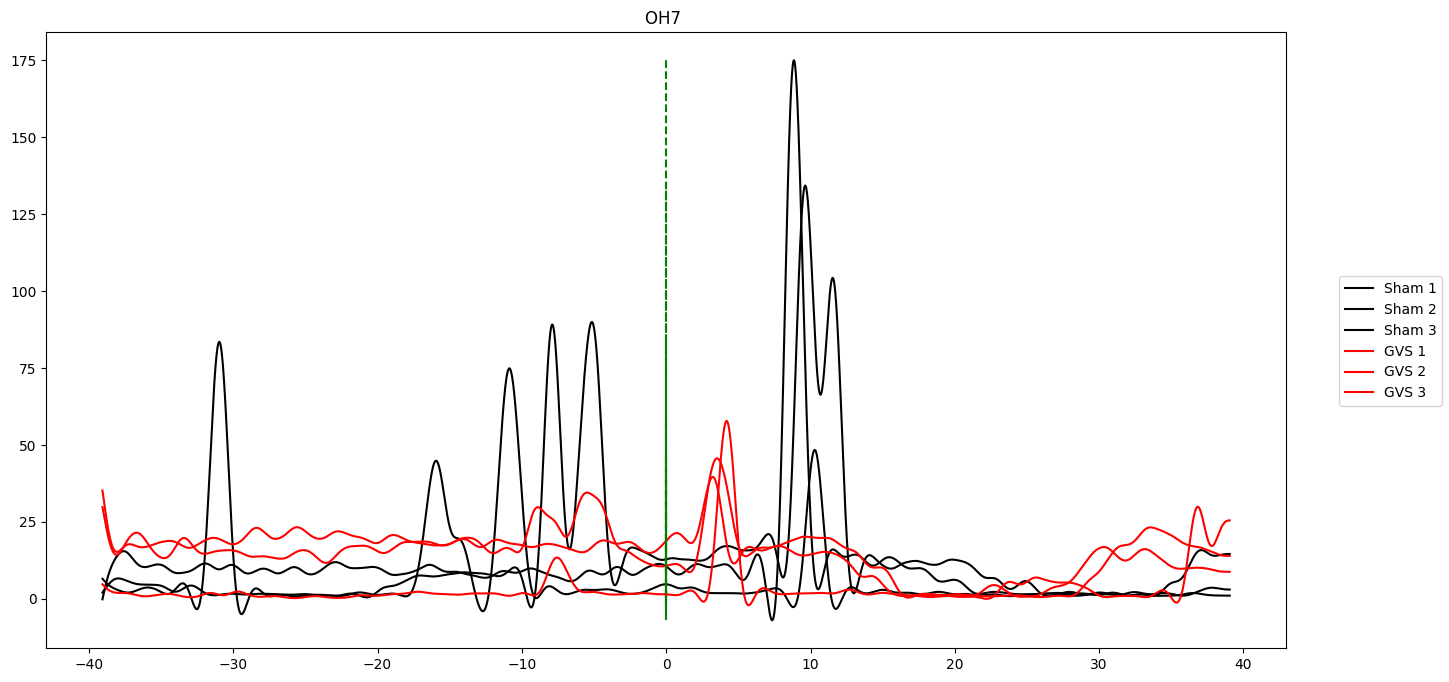

In [ ]:
loc = '/content/drive/MyDrive/DATA_untouched/OH07_May 3 2022_e4 data/'
standing_inds = [25, 30, 34, 4, 9, 14]
#offsets_ = plot_windows(loc, 7, standing_inds, 1, [-40, 200])
offsets_ = plot_windows(loc, 7, standing_inds)

#offsets.append(offsets_)

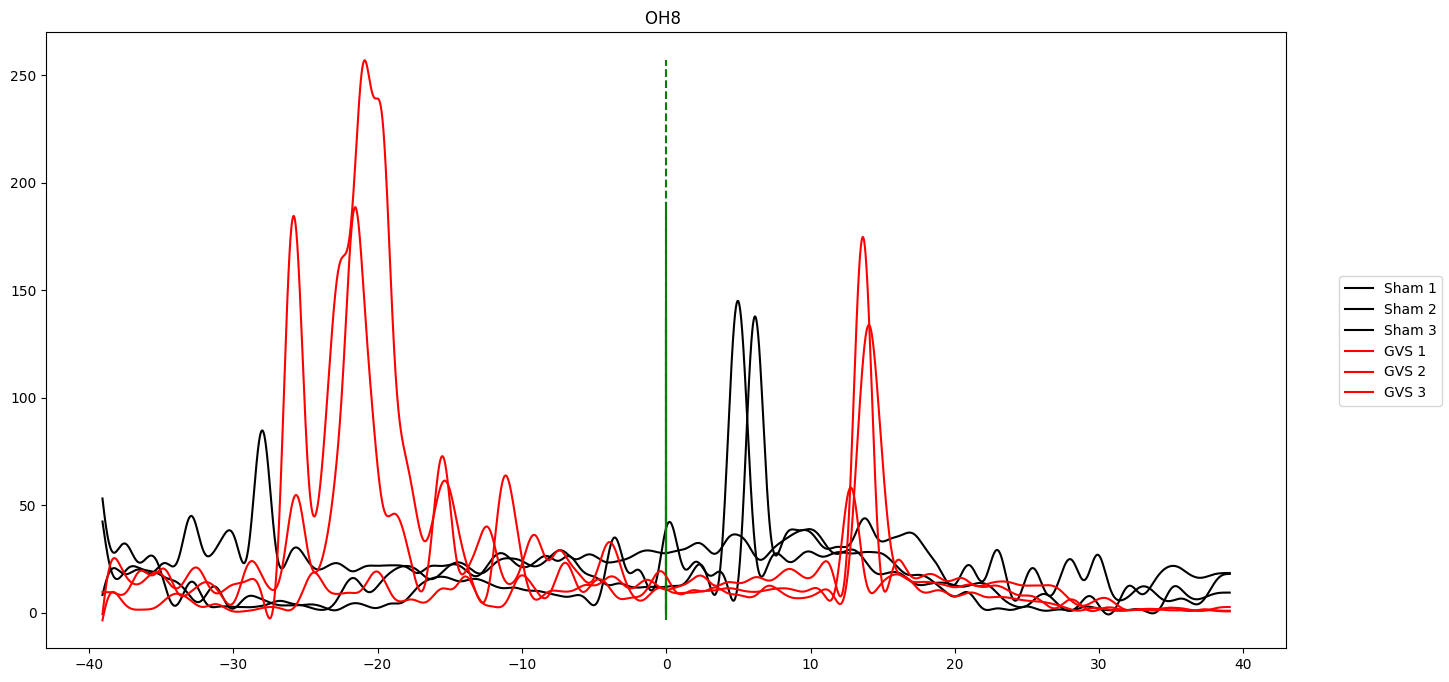

In [ ]:
loc = '/content/drive/MyDrive/DATA_untouched/OH08_May 4 2022_e4 data/'
standing_inds = [4, 9, 13, 20, 25, 30]
#offsets_ = plot_windows(loc, 8, standing_inds, 1, [-50, 200])
offsets_ = plot_windows(loc, 8, standing_inds)

#offsets.append(offsets_)

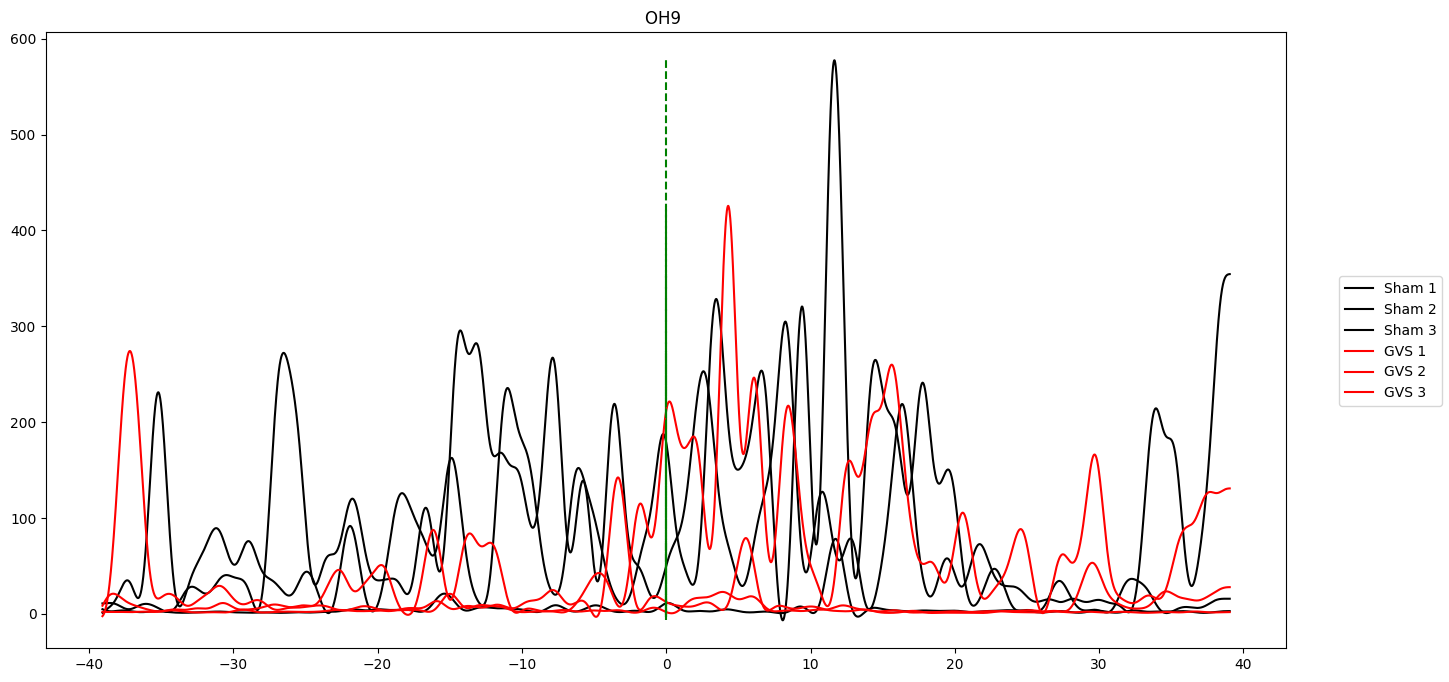

In [ ]:
loc = '/content/drive/MyDrive/DATA_untouched/OH09_May 5 2022_e4 data/'
standing_inds = [25, 30, 35, 4, 9, 14]
#offsets_ = plot_windows(loc, 9, standing_inds, 2, [-50, 500])
offsets_ = plot_windows(loc, 9, standing_inds)

#ffsets.append(offsets_)

In [ ]:
loc = '/content/drive/MyDrive/DATA_untouched/OH10_May 10 2022_e4 data/'
standing_inds = [25, 29, 33, 4, 9, 14]
#offsets_ = plot_windows(loc, 10, standing_inds, 1, [-50, 250])
offsets_ = plot_windows(loc, 10, standing_inds)

offsets.append(offsets_)

In [ ]:
loc = '/content/drive/MyDrive/DATA_untouched/OH11_May 16 2022_e4 data/'
standing_inds = [4, 9, 14, 26, 31, 36]
#offsets_ = plot_windows(loc, 11, standing_inds, 2, [-50, 150])
offsets_ = plot_windows(loc, 11, standing_inds)

offsets.append(offsets_)

In [ ]:
loc = '/content/drive/MyDrive/DATA_untouched/OH12_May 17 2022_e4 data/'
standing_inds = [25, 31, 36, 4, 9, 14]
offsets_ = plot_windows(loc, 12, standing_inds)
offsets.append(offsets_)

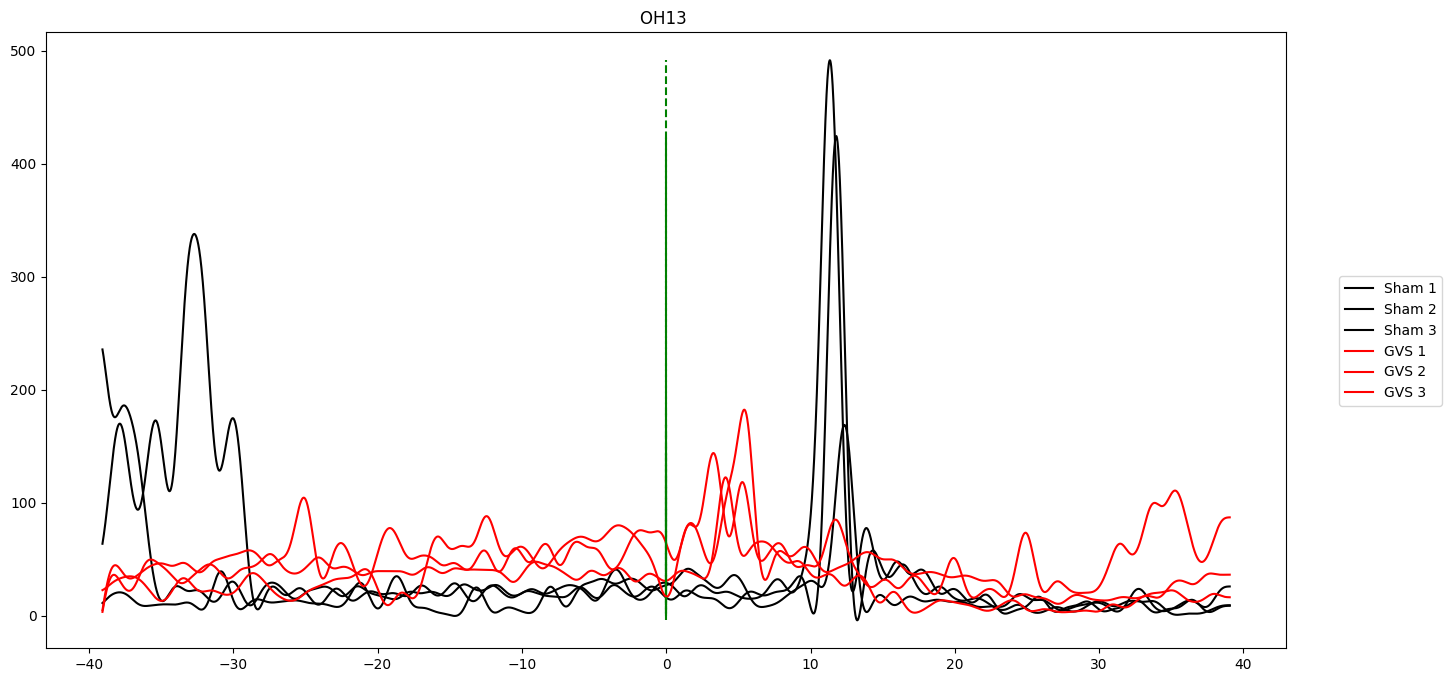

In [ ]:
loc = '/content/drive/MyDrive/DATA_untouched/OH13_May 18 2022_e4 data/'
standing_inds = [25, 30, 35, 4, 9, 14]
offsets_ = plot_windows(loc, 13, standing_inds)
offsets.append(offsets_)

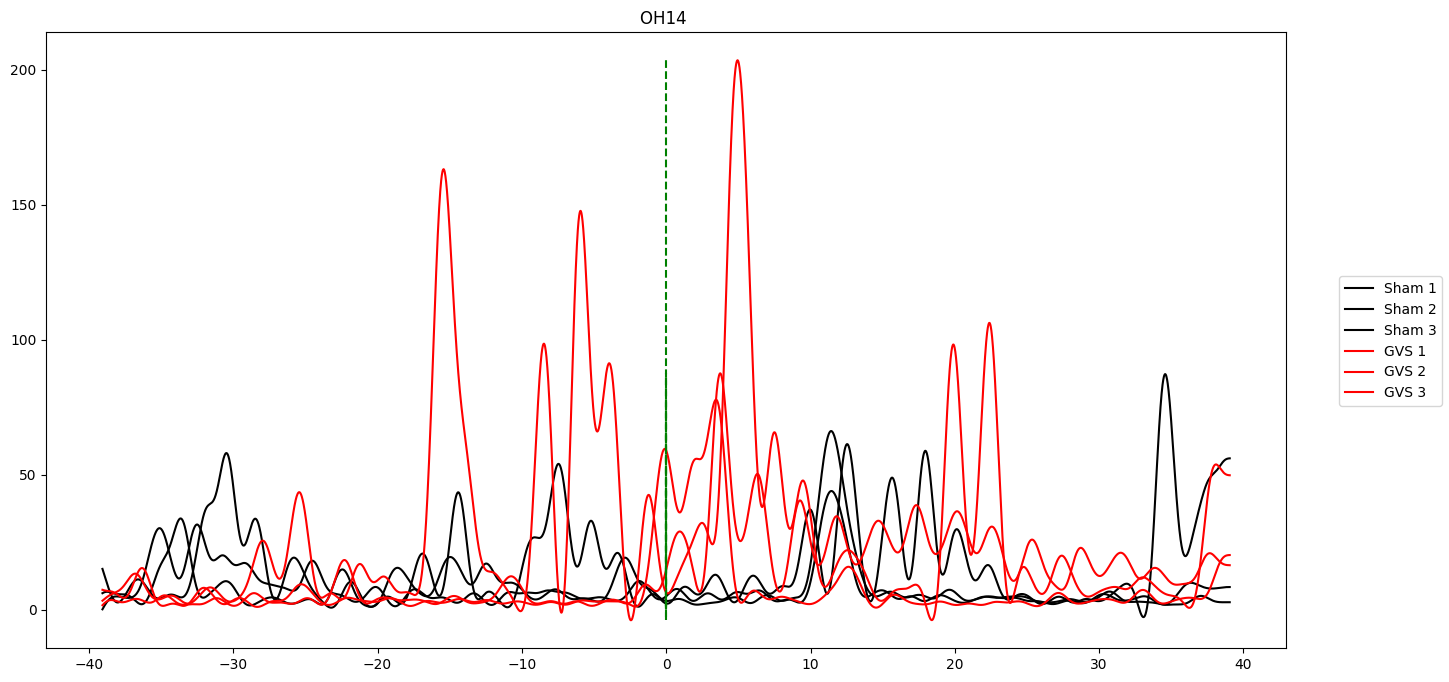

In [ ]:
loc = '/content/drive/MyDrive/DATA_untouched/OH14_May 19 2022_e4 data/'
standing_inds = [25, 30, 35, 4, 9, 14]
#offsets_ = plot_windows(loc, 14, standing_inds, 3, [-50, 300])
offsets_ = plot_windows(loc, 14, standing_inds)

offsets.append(offsets_)

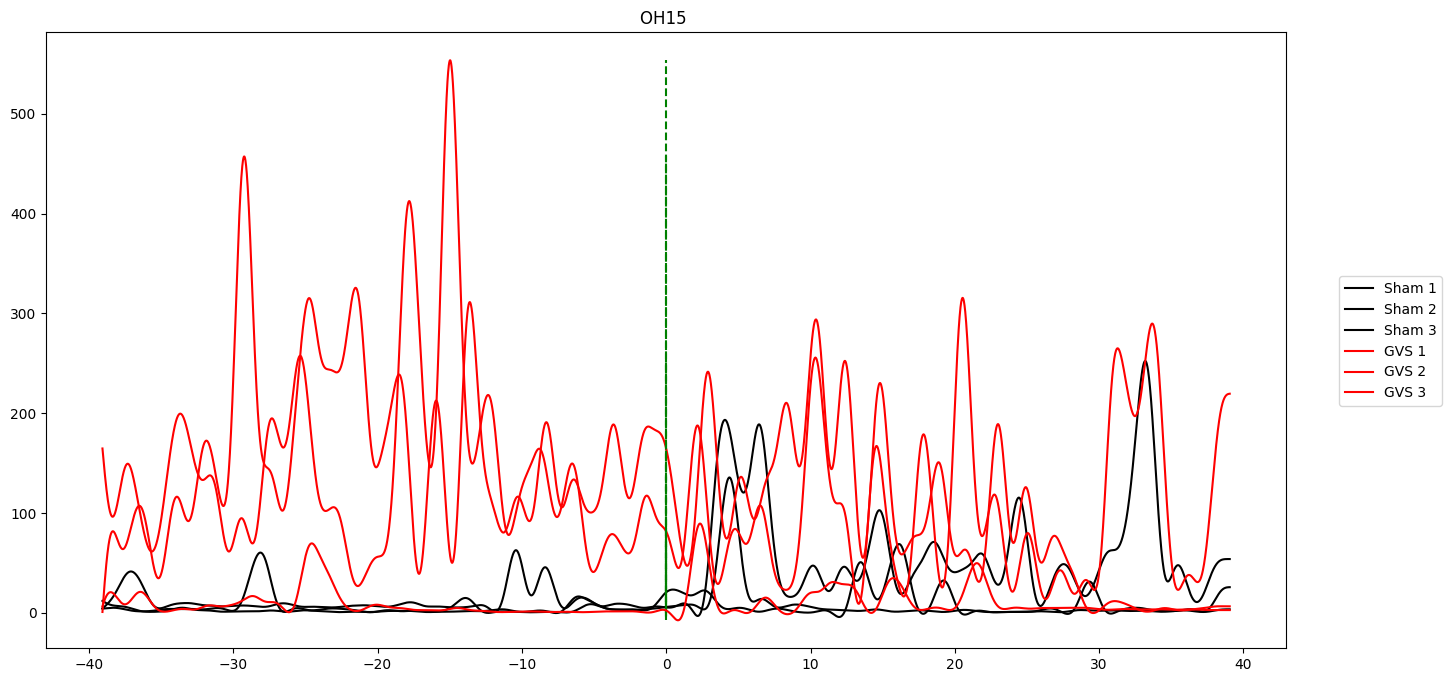

In [ ]:
loc = '/content/drive/MyDrive/DATA_untouched/OH15_May 25 2022_e4 data/'
standing_inds = [4, 10, 16, 27, 32, 37]
offsets_ = plot_windows(loc, 15, standing_inds)#, 1, [-50, 600])
offsets.append(offsets_)

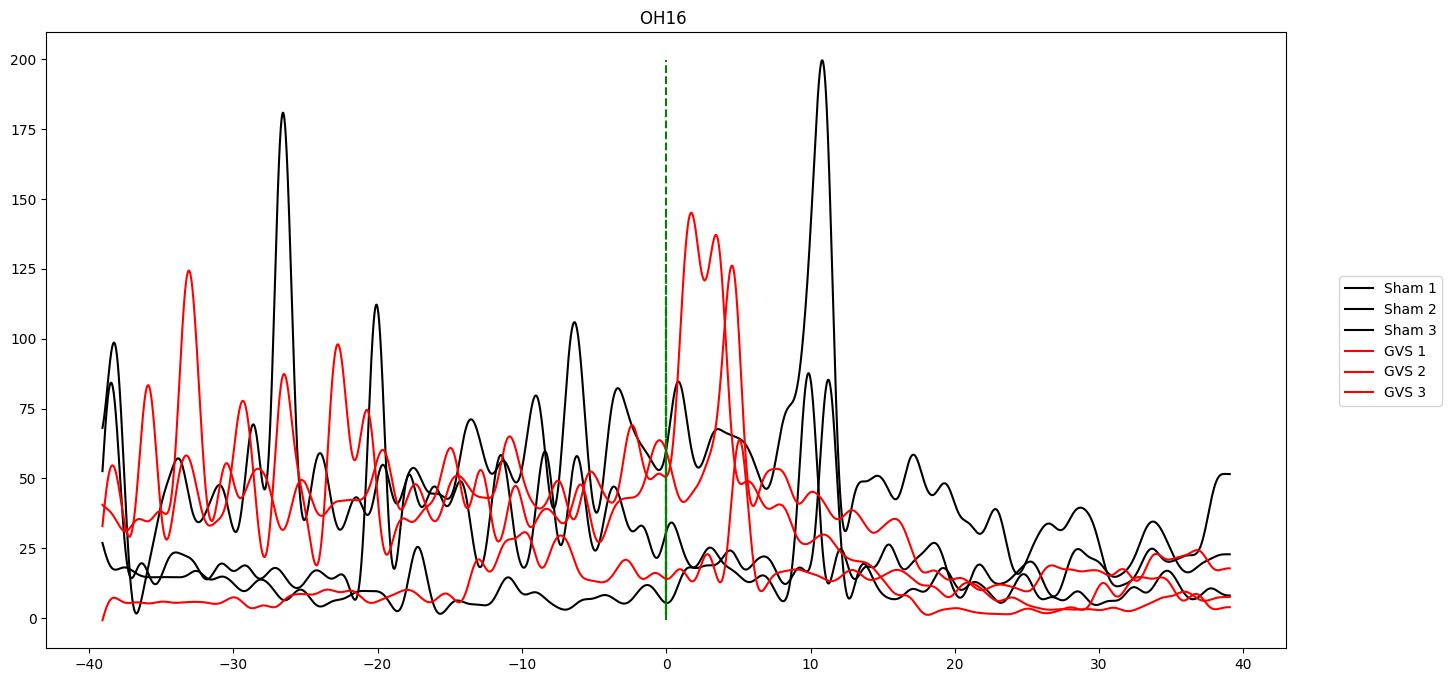

In [ ]:
loc = '/content/drive/MyDrive/DATA_untouched/OH16_May 27 2022_e4 data/'
standing_inds = [26, 34, 40, 4, 9, 14]
offsets_ = plot_windows(loc, 16, standing_inds)#, 1, [-50, 300])
offsets.append(offsets_)

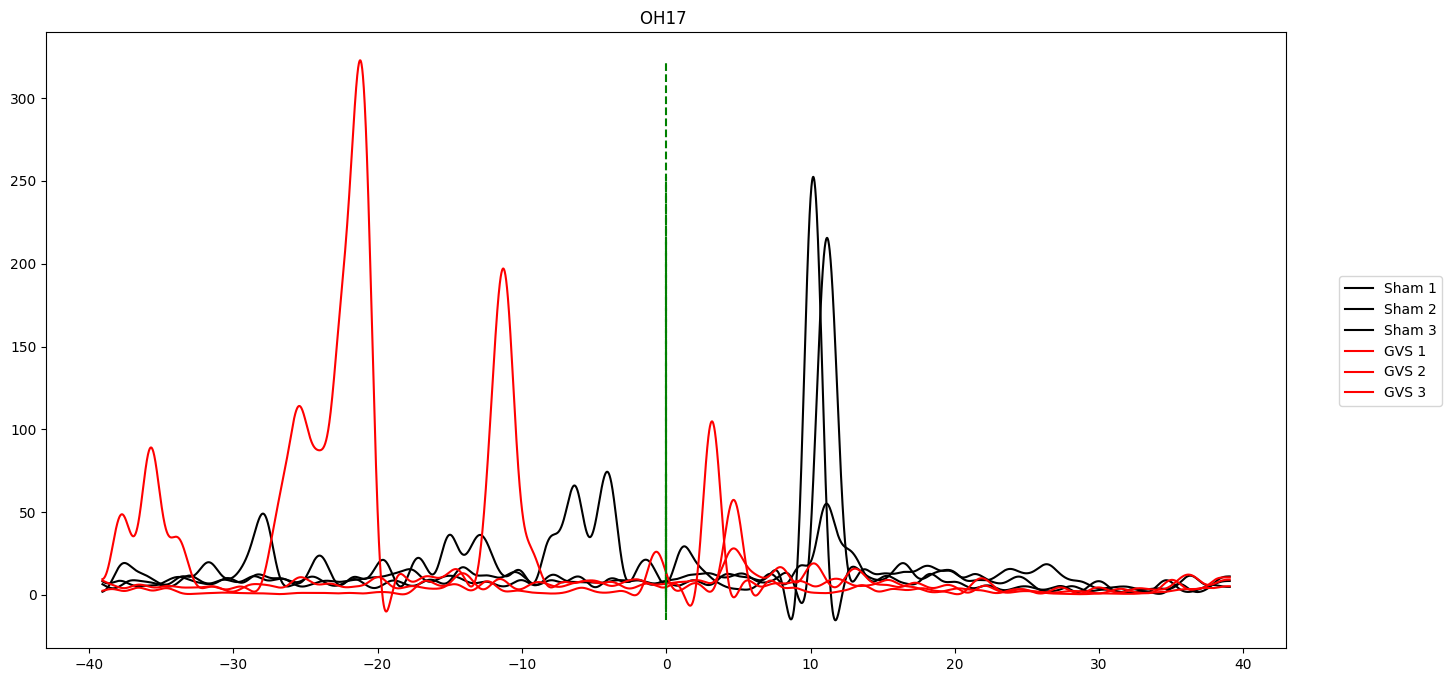

In [ ]:
loc = '/content/drive/MyDrive/DATA_untouched/OH17_May 30 2022_e4 data/'
standing_inds = [25, 30, 35, 4, 9, 14]
offsets_ = plot_windows(loc, 17, standing_inds)#, 1, [-50, 600])
offsets.append(offsets_)

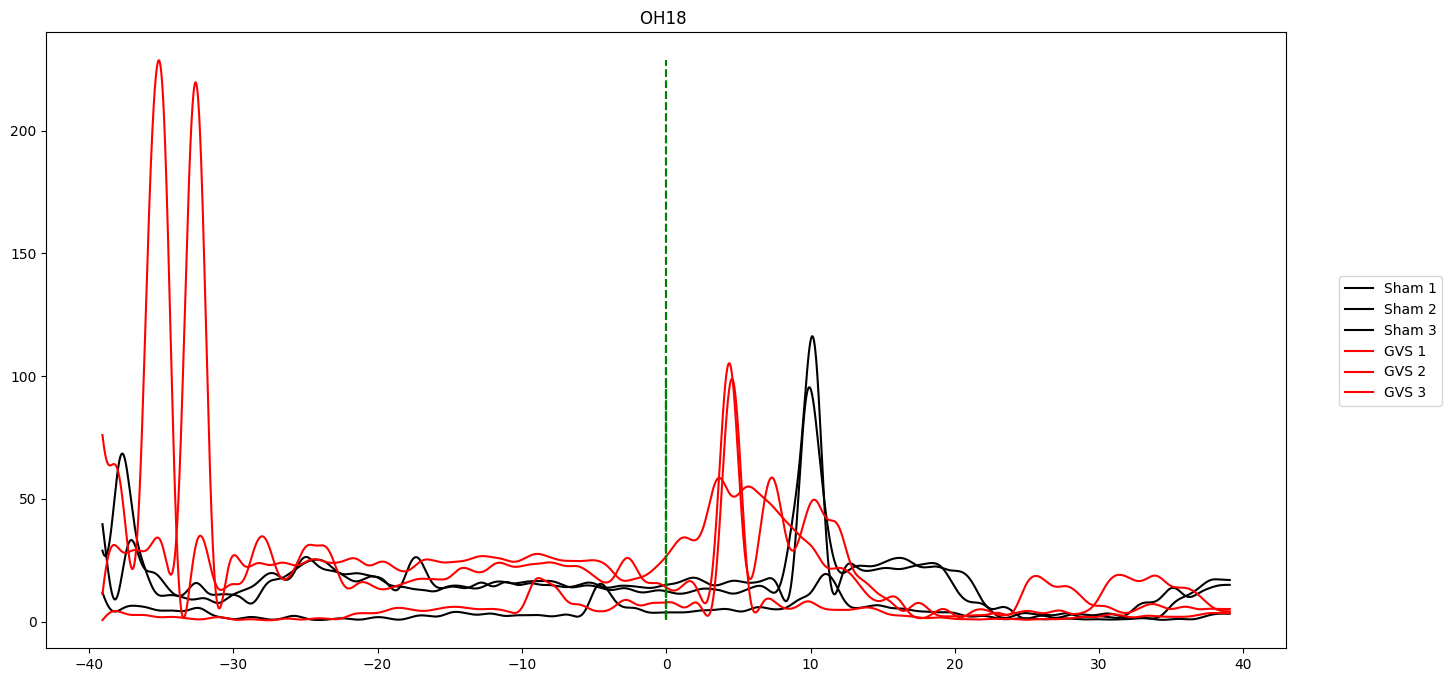

In [ ]:
loc = '/content/drive/MyDrive/DATA_untouched/OH18_June 1 2022_e4 data/'
standing_inds = [25, 30, 35, 4, 9, 14]
offsets_ = plot_windows(loc, 18, standing_inds)#, 1, [-50, 150])
offsets.append(offsets_)

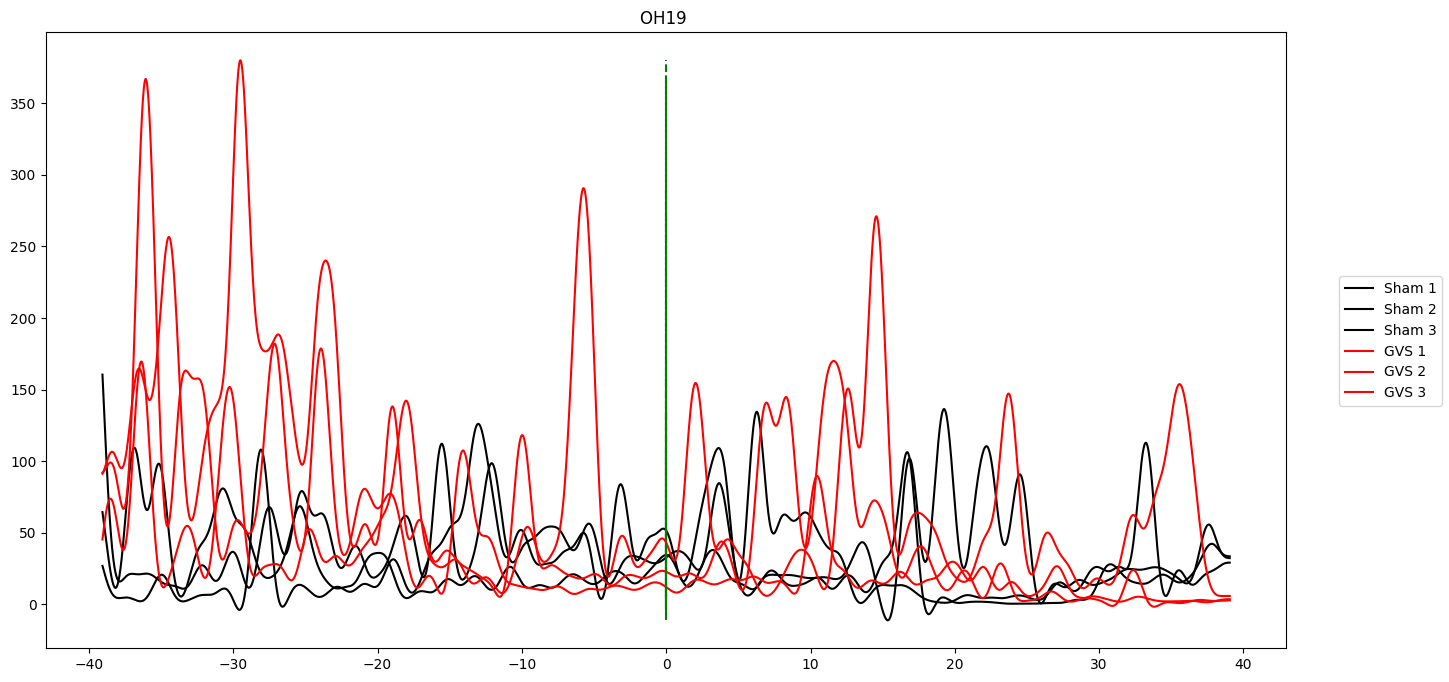

In [ ]:
loc = '/content/drive/MyDrive/DATA_untouched/OH19_June_8_2022_e4 data/'
standing_inds = [4, 9, 14, 27, 32, 37]
offsets_ = plot_windows(loc, 19, standing_inds)#, 3, [-50, 400])
offsets.append(offsets_)

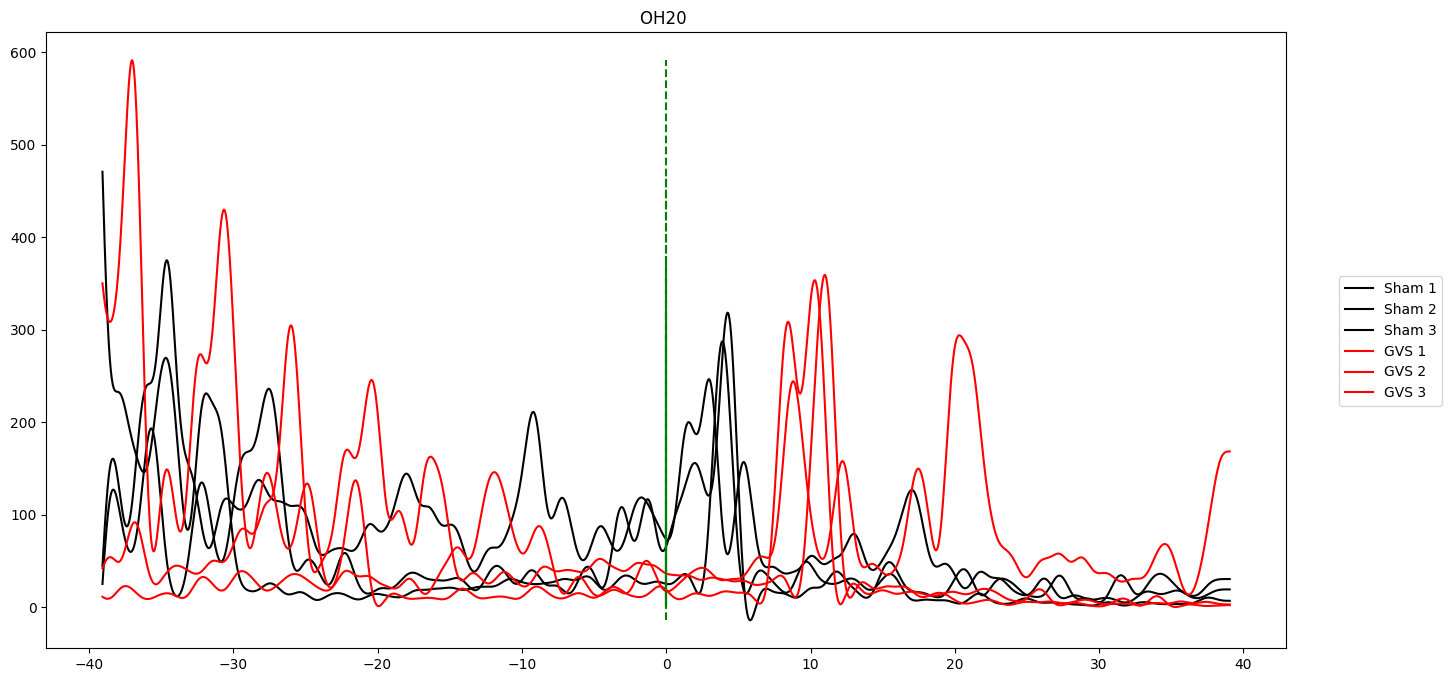

In [ ]:
loc = '/content/drive/MyDrive/DATA_untouched/OH20_June_8_2022_e4 data/'
standing_inds = [4, 9, 14, 25, 30, 35]
offsets_ = plot_windows(loc, 20, standing_inds)#, 3, [-50, 400])
offsets.append(offsets_)

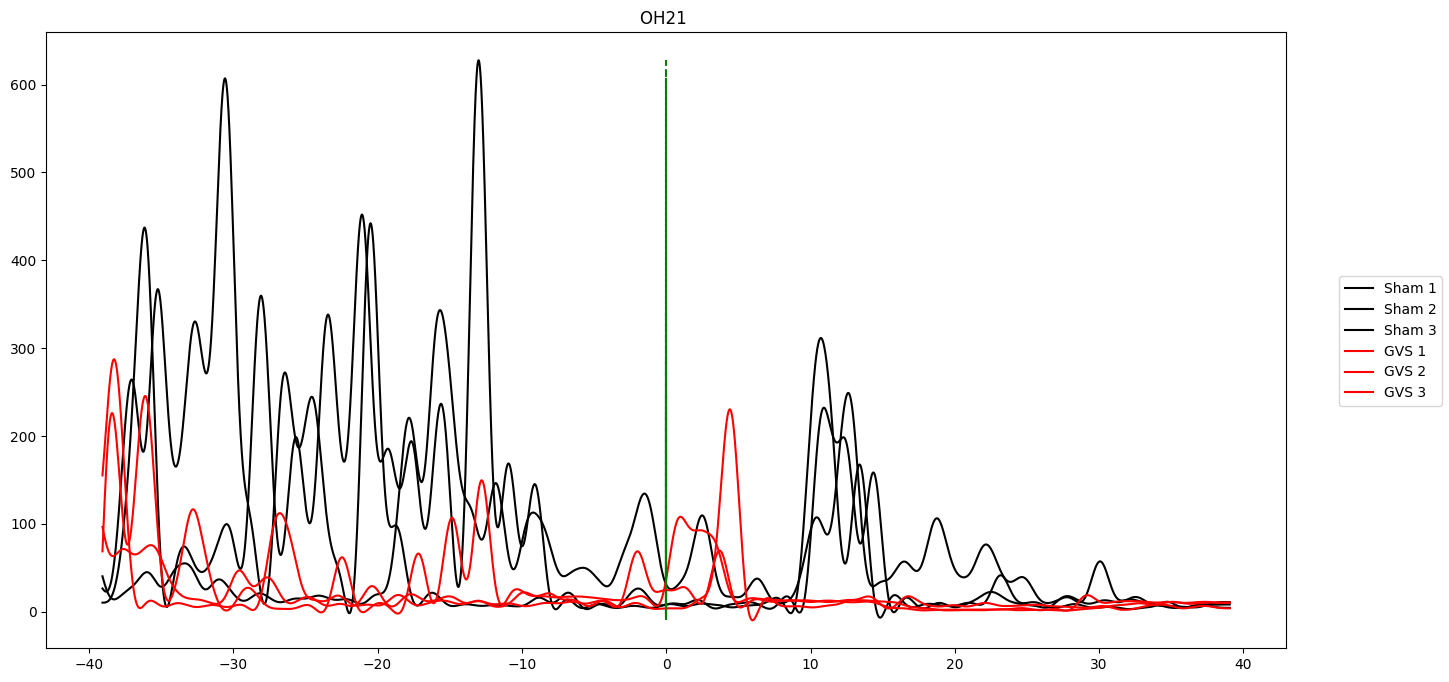

In [ ]:
loc = '/content/drive/MyDrive/DATA_untouched/OH21_June_9_2022_e4 data/'
standing_inds = [25, 30, 35, 4, 9, 14]
offsets_ = plot_windows(loc, 21, standing_inds)
offsets.append(offsets_)

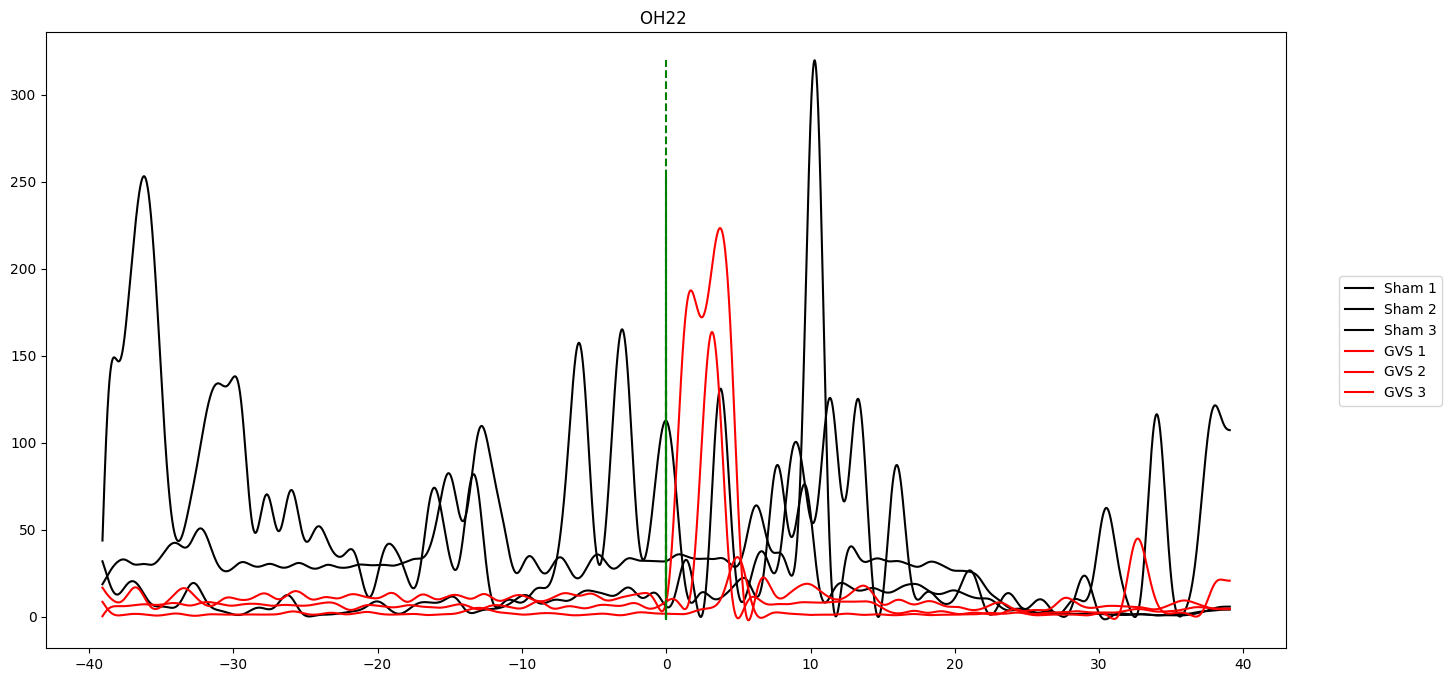

In [ ]:
loc = '/content/drive/MyDrive/DATA_untouched/OH22_June_10_2022_e4 data/'
standing_inds = [25, 30, 35, 4, 9, 14]
offsets_ = plot_windows(loc, 22, standing_inds)#, 1, [-50, 300])
offsets.append(offsets_)

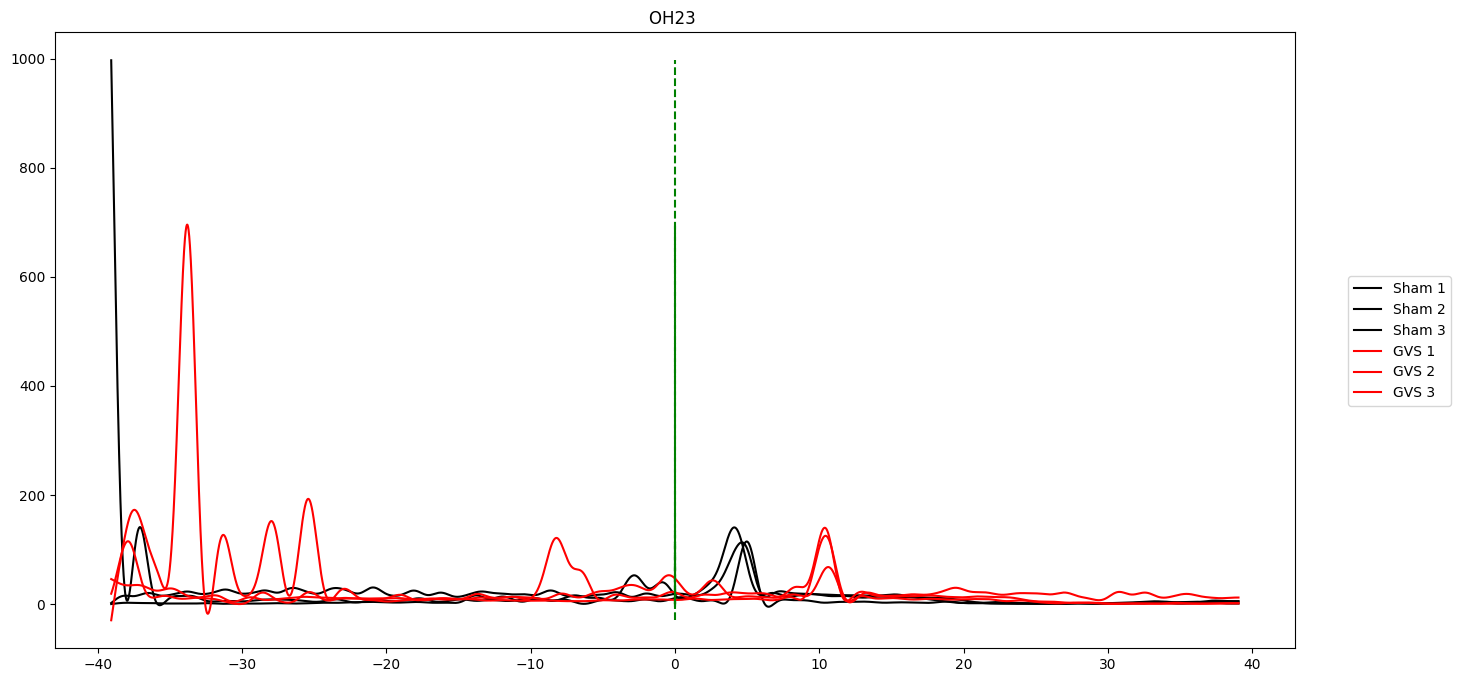

In [ ]:
loc = '/content/drive/MyDrive/DATA_untouched/OH23_June_13_2022_e4 data/'
standing_inds = [4, 9, 14, 25, 30, 35]
offsets_ = plot_windows(loc, 23, standing_inds)#, 1, [-50, 250])
offsets.append(offsets_)

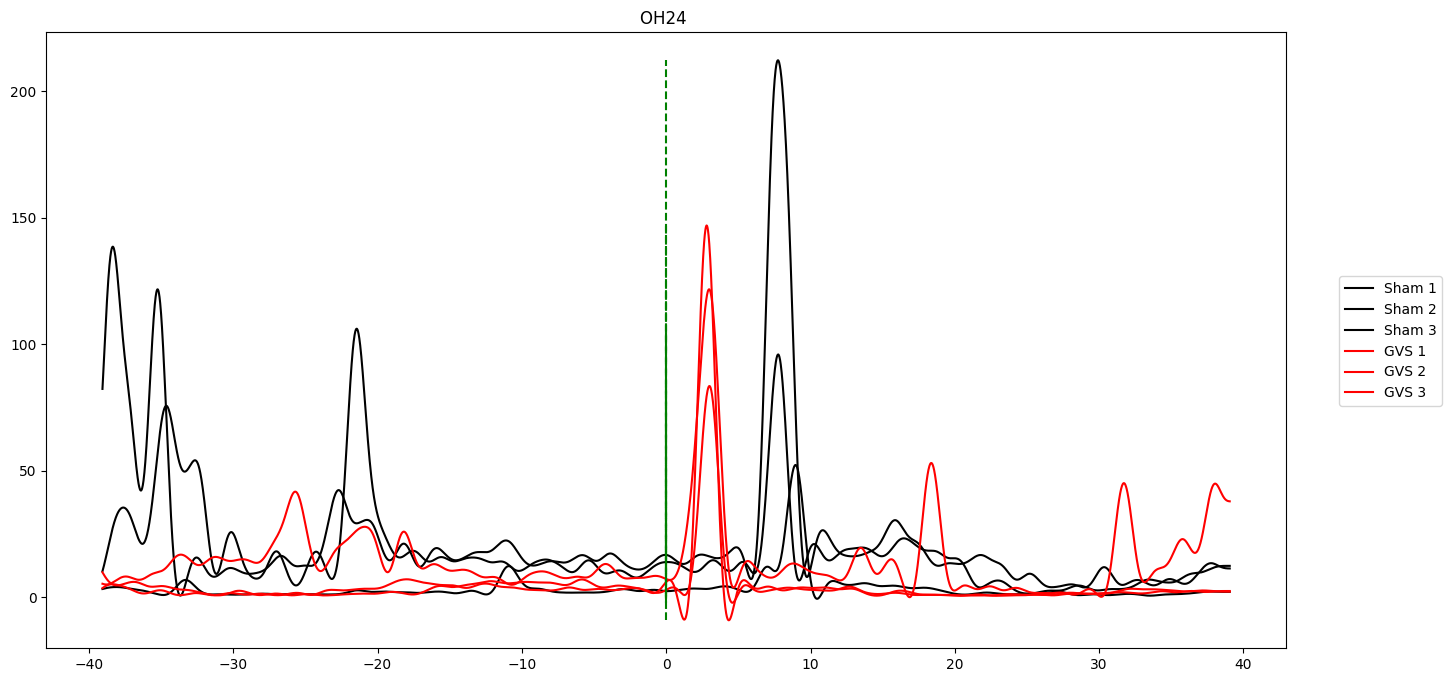

In [ ]:
loc = '/content/drive/MyDrive/DATA_untouched/OH24_June_14_2022_e4 data/'
standing_inds = [26, 31, 36, 4, 9, 14]
offsets_ = plot_windows(loc, 24, standing_inds)#, 1, [-50, 300])
offsets.append(offsets_)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:191: RuntimeWarning: invalid value encountered in long_scalars
  ret = ret / rcount
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:264: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,


ZeroDivisionError: ignored

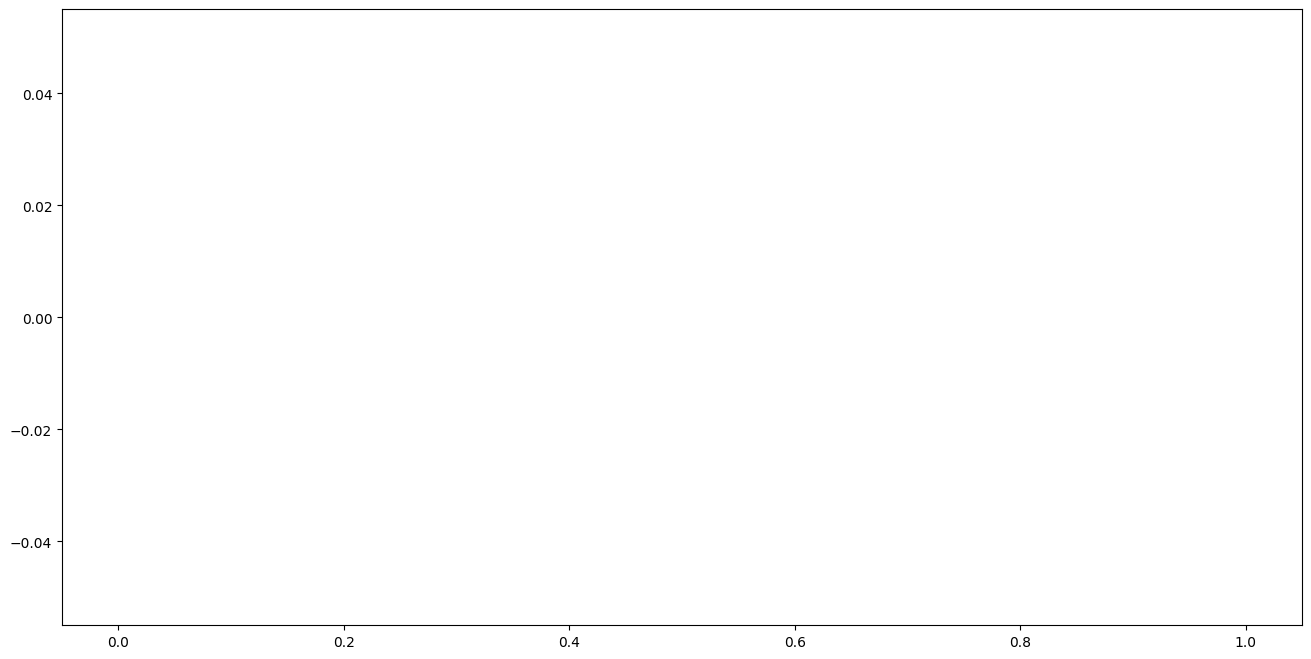

In [ ]:
offsets = np.array(offsets)
offsets = offsets.flatten()
offsets = offsets[offsets != None]
plt.figure()
plt.hist(offsets)
plt.title('Histogram of Offsets'+' (Mean = '+"{:.3f}".format(np.mean(offsets))+', STD = ' +"{:.3f}".format(np.std(offsets)) +')')
plt.show()

print(np.mean(offsets))
print(np.std(offsets))

In [ ]:
!zip -r /content/BVP_plots.zip /content/BVP_plots